# Tutorial: Brd4 bindings for Male/Female mouse bulk calling cards data. 

 We will analyze bulk calling cards datasets from [Kfoury et al., PNAS. (2021)](https://www.pnas.org/doi/10.1073/pnas.2017148118), which can be downloaded from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE156821). These experiments were designed to study differences in Brd4 binding between male and female cells in a genetically engineered cellular model of glioblastoma (GBM). These nearly-isogenic cells were derived from murine neocortical postnatal day 1 (p1) astrocytes (male and female GBM astrocytes) and were engineered to contain a combined loss of neurofibromin (NF1) and p53 function. These cells were previously shown to display sex differences in important GBM  phenotypes in vivo, including proliferation, clonogenic stem-like frequency, in vivo tumorigenesis, cell cycle regulation, gene expression, and chemotherapy response, that mimic those observed in GBM patients. For more details see [Kfoury et al., PNAS. (2021)].

 In this tutorial, we will call peaks, annotate these peaks, perform differential peak analysis, and pair differentially bound genomic regions with nearby genes that are also differentially expressed between the sexes. There are 668525 insertions in female qbed data and 613728 insertions in male qbed data. For bulk RNA-seq data, there are 6 samples in total: 3 female samples and 3 male samples. It creates a group by peak anndata for calling cards data. If you want to create a replicate by peak anndata only, please check [Github](https://github.com/The-Mitra-Lab/pycallingcards_data/blob/main/Brd4_bulk-replicate.ipynb)

In [1]:
import pycallingcards as cc
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 150

We start by reading qbed data. In these data, each row provides information about one Brd4-directed insertion organized into columns to indicate the chromosome, start point, end point, number of reads supporting the insertion, and the orientation and barcode for each insertion. For example, in the file displayed below, the first row tells us that the first insertion occured into a TTAA on Chromosome 1, whose coordinates start location 3478112 and end at 3478115. There was 1 read supporting this insertion and the transposon is orientated so that the plus strand of the transposon is on the plus strand of the genome. The transposon barcode is TTTGTCCAA. We add another column indecating its respected group. 

Use ```cc.rd.read_qbed(filename)``` to load your own qbed data.

In [2]:
Female_Brd4 = cc.datasets.mouse_brd4_data(data = "Female_Brd4")
Female_Brd4['group'] = "Female_Brd4"
Female_Brd4
#load female CC data

,Chr,Start,End,Reads,Direction,Barcodes,group
0,chr1,3478111,3478115,1,+,TTTGTCCAA,Female_Brd4
1,chr1,3481743,3481747,1,+,TATGTACAA,Female_Brd4
2,chr1,3481957,3481961,1,-,TATGTACAA,Female_Brd4
3,chr1,3493161,3493165,16,+,TATGTACAA,Female_Brd4
4,chr1,3493702,3493706,1,+,CGTTACACA,Female_Brd4
...,...,...,...,...,...,...,...
1290214,chrY,90802841,90802845,1,-,CGTTACACA,Female_Brd4
1290215,chrY,90803579,90803583,1,-,TATGTACAA,Female_Brd4
1290216,chrY,90803579,90803583,1,-,TGTCGTGCA,Female_Brd4
1290217,chrY,90804429,90804433,1,-,TATACTCTA,Female_Brd4


In [3]:
Male_Brd4 = cc.datasets.mouse_brd4_data(data = "Male_Brd4")
Male_Brd4['group'] = "Male_Brd4"
Male_Brd4
#load male CC data

,Chr,Start,End,Reads,Direction,Barcodes,group
0,chr1,3493161,3493165,1,-,GAGGTACAG,Male_Brd4
1,chr1,3493275,3493279,1,+,TACTTTCCG,Male_Brd4
2,chr1,3493341,3493345,2,+,AGCACAGTG,Male_Brd4
3,chr1,3493341,3493345,10,+,TGTCCATTG,Male_Brd4
4,chr1,3493341,3493345,8,+,ATGAAAGCA,Male_Brd4
...,...,...,...,...,...,...,...
1185697,chrY,90803733,90803737,13,-,TACTTTCCG,Male_Brd4
1185698,chrY,90803733,90803737,9,-,CACGGCGGA,Male_Brd4
1185699,chrY,90803733,90803737,17,-,GATCTTATG,Male_Brd4
1185700,chrY,90803774,90803778,4,-,ATGAAAGCA,Male_Brd4


Since we are interested in differential peak calling, we now combine the two datasets to call peaks on the joint dataset:

In [4]:
Brd4 = cc.rd.combine_qbed([Female_Brd4, Male_Brd4])
Brd4

,Chr,Start,End,Reads,Direction,Barcodes,group
0,chr1,3478111,3478115,1,+,TTTGTCCAA,Female_Brd4
1,chr1,3481743,3481747,1,+,TATGTACAA,Female_Brd4
2,chr1,3481957,3481961,1,-,TATGTACAA,Female_Brd4
3,chr1,3493161,3493165,16,+,TATGTACAA,Female_Brd4
4,chr1,3493161,3493165,1,-,GAGGTACAG,Male_Brd4
...,...,...,...,...,...,...,...
2475916,chrY,90803733,90803737,17,-,GATCTTATG,Male_Brd4
2475917,chrY,90803774,90803778,4,-,ATGAAAGCA,Male_Brd4
2475918,chrY,90804429,90804433,1,-,TATACTCTA,Female_Brd4
2475919,chrY,90805130,90805134,1,-,GACGGCTCC,Female_Brd4


Optional: filter the insertions with reads greater than 2. Because we use strict quality control on read insertions, even insertions supported by 1 read are likely to be bona fide.

In [5]:
Brd4 = Brd4[Brd4['Reads'] > 2]
Brd4

,Chr,Start,End,Reads,Direction,Barcodes,group
3,chr1,3493161,3493165,16,+,TATGTACAA,Female_Brd4
7,chr1,3493341,3493345,10,+,TGTCCATTG,Male_Brd4
8,chr1,3493341,3493345,8,+,ATGAAAGCA,Male_Brd4
10,chr1,3493643,3493647,3,+,TCTACTGCC,Male_Brd4
17,chr1,3514553,3514557,7,+,TACTTTCCG,Male_Brd4
...,...,...,...,...,...,...,...
2475905,chrY,42512546,42512550,3,-,ACGCGCTGT,Male_Brd4
2475914,chrY,90803733,90803737,13,-,TACTTTCCG,Male_Brd4
2475915,chrY,90803733,90803737,9,-,CACGGCGGA,Male_Brd4
2475916,chrY,90803733,90803737,17,-,GATCTTATG,Male_Brd4


Because insertions are discrete, we now need to call peaks to deduce potential binding sites. Three different methods (*CCcaller, MACCS, Blockify*) are available along with three different species (*hg38, mm10, yeast*). 

In this setting, we use ***CCcaller*** in *mouse*('mm10') data. *maxbetween* is the most important parameter for *CCcaller*. It controls the maximum distance between two nearby insertions, or in another words, the minimum distance between two peaks. We recommend using a value between 800-2500 to set *maxbetween*.  *pvalue_cutoff* is also an important parameter, and a number below 0.05 is strongly advised (often well below).

In [6]:
peak_data = cc.pp.call_peaks(Brd4, method = "CCcaller", reference = "mm10", pvalue_cutoff = 0.01, 
                             maxbetween = 1100, lam_win_size = 1000000, pseudocounts = 0.1, 
                             record = True, save = "peak.bed")
peak_data

For the CCcaller method without background, [expdata, reference, pvalue_cutoff, lam_win_size, pseudocounts, minlen, extend, maxbetween, test_method, min_insertions, record] would be utilized.


100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


,Chr,Start,End,Experiment Insertions,Reference Insertions,Expected Insertions,pvalue,pvalue_adj
0,chr1,4196775,4198714,16,12,0.142389,0.000000e+00,0.000000e+00
1,chr1,4785068,4786551,17,15,0.572576,0.000000e+00,0.000000e+00
2,chr1,4806673,4807730,21,12,0.477937,0.000000e+00,0.000000e+00
3,chr1,4856928,4862019,104,44,1.490080,0.000000e+00,0.000000e+00
4,chr1,4912814,4916593,7,22,0.791756,1.900897e-06,1.024407e-04
...,...,...,...,...,...,...,...,...
24546,chrX,169936677,169937745,7,8,1.189526,3.479200e-05,1.673495e-03
24547,chrY,897430,899700,11,24,0.528165,6.046275e-13,5.162843e-11
24548,chrY,1009018,1011799,27,25,0.489073,0.000000e+00,0.000000e+00
24549,chrY,1243715,1246316,24,29,0.504932,0.000000e+00,0.000000e+00



In order to tune parameters for peak calling, we advise looking at the data and evaluating the validity of the called peaks. The default settings are what we recommend, but for some TFs adjacent peaks may be merged that should not be, or, alternatively, peaks that should be joined may be called separately. 

Below, we plot the combined calling card data in males and females for a region in chromosome 1. The top track displays insertion locations and their read counts. Each dot is an insertion and the height is log(reads+1). The middle track plots the insertion density. The thrid track represents the reference genes and peaks. Finally, the last track represents peak calls.  Below you can see that regions with high densities of insertions are accurately called as Brd4 binding sites.

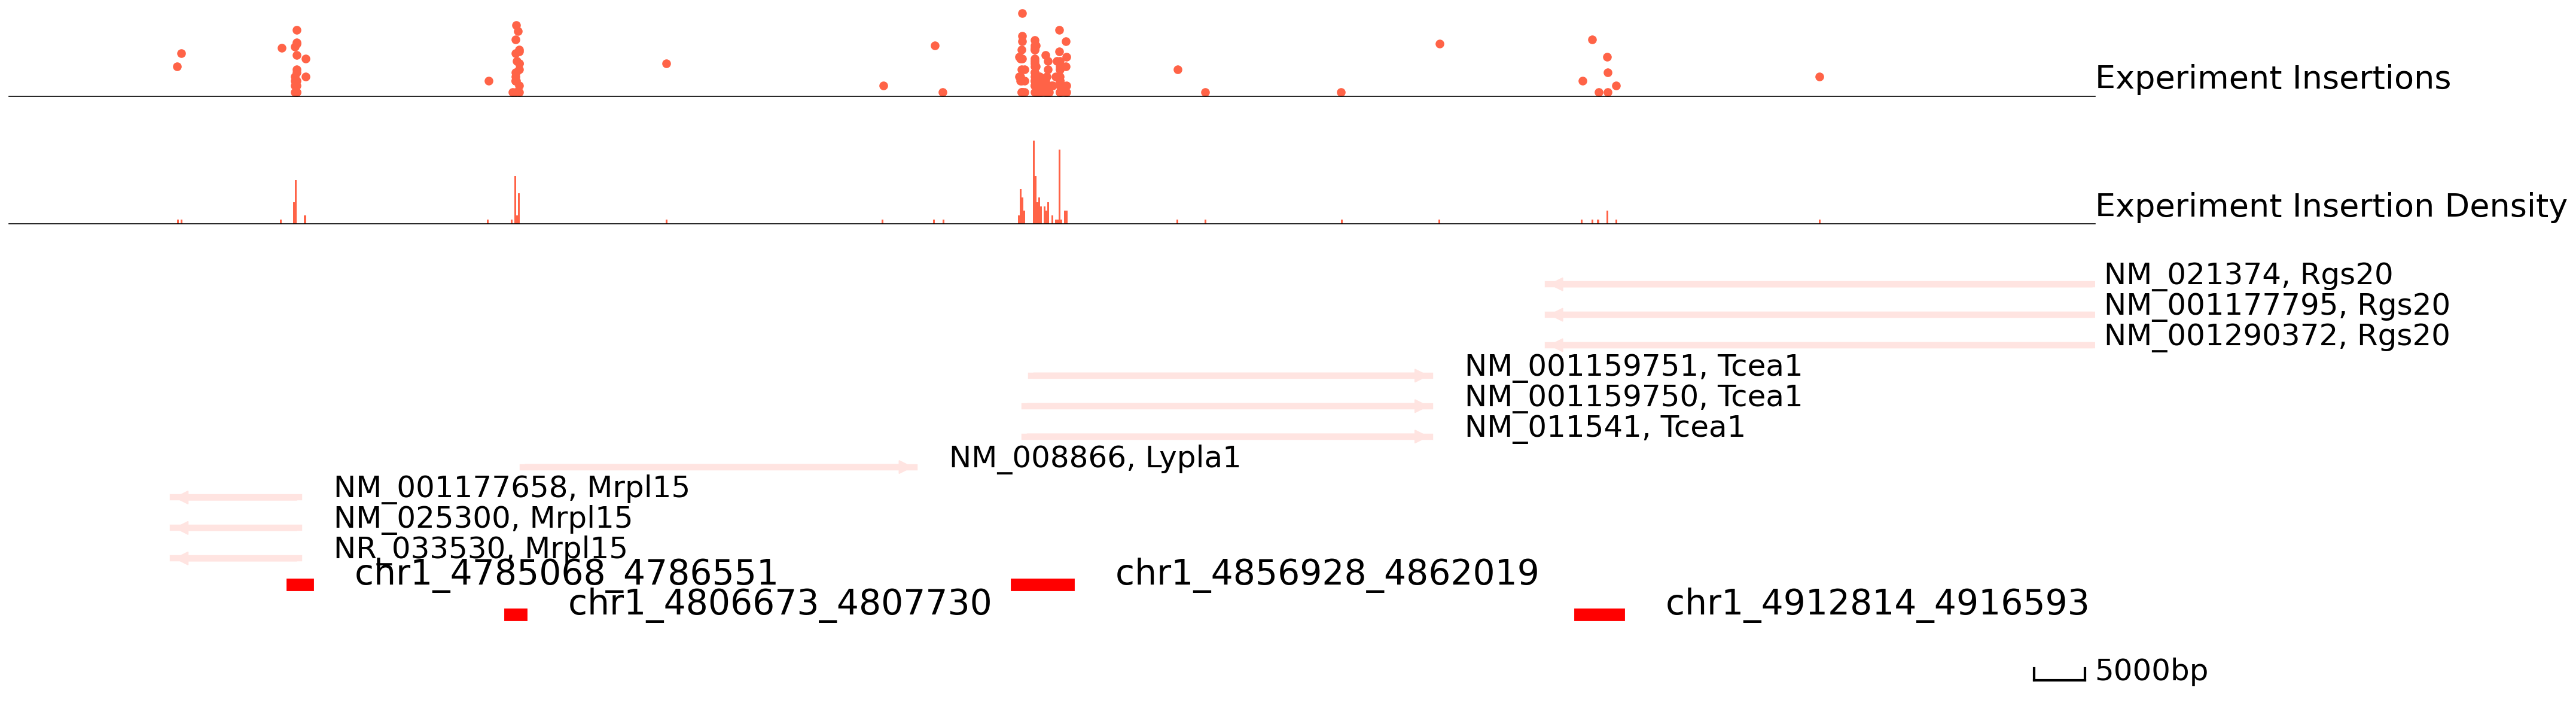

In [7]:
cc.pl.draw_area("chr1", 4856929, 4863861, 100000, peak_data, Brd4, "mm10", font_size = 2, 
                plotsize = [1,1,5], 
                figsize = (30,10), peak_line = 2, save = False, example_length = 5000)

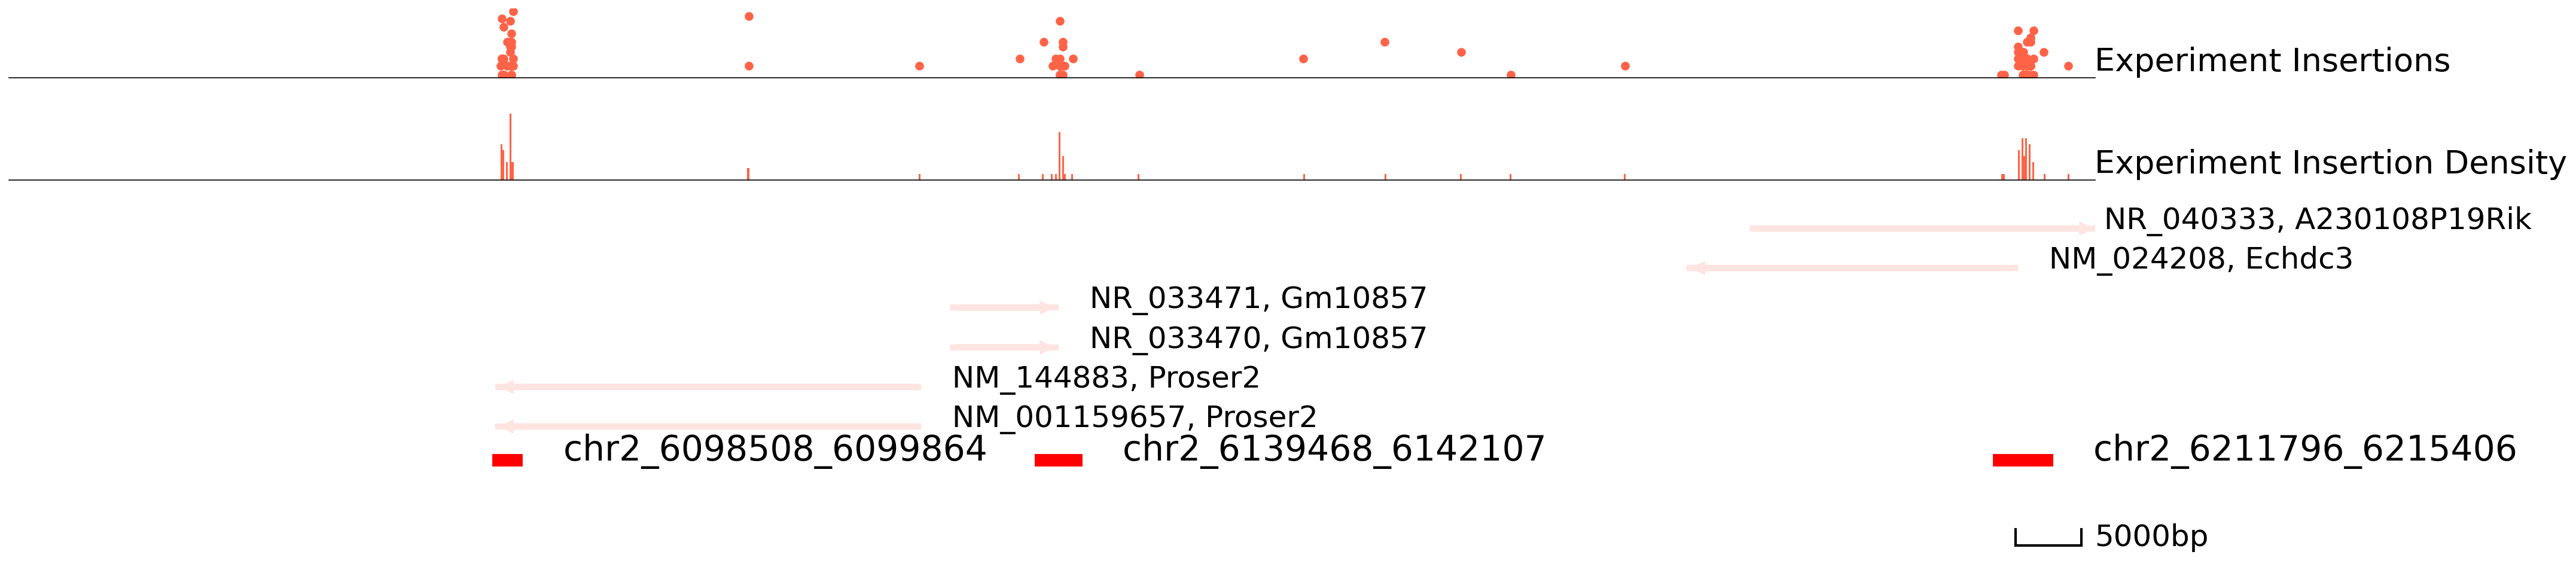

In [8]:
cc.pl.draw_area("chr2", 6136575, 6144043, 75000, peak_data, Brd4, "mm10", font_size = 2, plotsize = [1,1,5],
                figsize = (30,8), peak_line = 1, save = False, example_length = 5000)

We can also visualize our data directly in the [WashU Epigenome Browser](http://epigenomegateway.wustl.edu/browser/). This can be useful for overlaying your data with other published datasets. Notice that this link only valid for 24hrs, so please rerun it if you want to use it.

In [9]:
qbed = {"Brd4": Brd4}
bed = {"peak": peak_data}
cc.pl.WashU_browser_url(qbed = qbed, bed = bed, genome = 'mm10')

All qbed addressed
All bed addressed
Uploading files
Please click the following link to see the data on WashU Epigenome Browser directly.
https://epigenomegateway.wustl.edu/browser/?genome=mm10&hub=https://companion.epigenomegateway.org//task/14d228099b68bf34c6514e0bcb625084/output//datahub.json


Pycallingcards can be used to visual peak locations acorss the genome to see if the distribution of peaks is unbiased and all chromosomes are represented.

In [10]:
cc.pl.whole_peaks(peak_data, reference = "mm10", linewidth = 1)

For differential peak calling, we recommend first combining the data and calling peaks together (and then splitting the data and looking for enrichments under the jointly called peaks). However, it is often of interest to call peaks in each sample to analyze them separately or to then merge these peak calls using [pybedtools](https://daler.github.io/pybedtools/). Below is the code to do this:

```python
import pybedtools
peak_data1 = cc.pp.call_peaks(Female_Brd4, method = "CCcaller", 
                              reference = "mm10", pvalue_cutoffbg = 0.1, 
                              maxbetween = 2000, pvalue_cutoffTTAA = 0.001, 
                              lam_win_size = 1000000,  pseudocounts = 0.1, record = True)
peak_data2 = cc.pp.call_peaks(Male_Brd4, method = "CCcaller", 
                              reference = "mm10",  pvalue_cutoffbg = 0.1, 
                              maxbetween = 2000, pvalue_cutoffTTAA = 0.001, 
                              lam_win_size = 1000000, pseudocounts = 0.1, record = True)
peak = cc.rd.combine_qbed([peak_data1, peak_data2])
peak = pybedtools.BedTool.from_dataframe(peak).merge().to_dataframe() 
peak_data = peak.rename(columns={"chrom":"Chr", "start":"Start", "end":"End"})
```

In the next step, we annote each peak to annotate using [bedtools](https://bedtools.readthedocs.io/en/latest/) and [pybedtools](https://daler.github.io/pybedtools/).
Make sure they are all previously installed before using.

In [11]:
peak_annotation = cc.pp.annotation(peak_data, reference = "mm10")
peak_annotation = cc.pp.combine_annotation(peak_data, peak_annotation)
peak_annotation

In the bedtools method, we would use bedtools in the default path. Set bedtools path by 'bedtools_path' if needed.


,Chr,Start,End,Experiment Insertions,Reference Insertions,Expected Insertions,pvalue,pvalue_adj,Nearest Refseq1,Gene Name1,Nearest Refseq2,Gene Name2
0,chr1,4196775,4198714,16,12,0.142389,0.000000e+00,0.000000e+00,NM_001195662,Rp1,NM_011283,Rp1
1,chr1,4785068,4786551,17,15,0.572576,0.000000e+00,0.000000e+00,NR_033530,Mrpl15,NM_008866,Lypla1
2,chr1,4806673,4807730,21,12,0.477937,0.000000e+00,0.000000e+00,NM_008866,Lypla1,NR_033530,Mrpl15
3,chr1,4856928,4862019,104,44,1.490080,0.000000e+00,0.000000e+00,NM_011541,Tcea1,NM_008866,Lypla1
4,chr1,4912814,4916593,7,22,0.791756,1.900897e-06,1.024407e-04,NM_001290372,Rgs20,NM_011541,Tcea1
...,...,...,...,...,...,...,...,...,...,...,...,...
24546,chrX,169936677,169937745,7,8,1.189526,3.479200e-05,1.673495e-03,NM_010797,Mid1,NR_029457,G530011O06Rik
24547,chrY,897430,899700,11,24,0.528165,6.046275e-13,5.162843e-11,NM_011419,Kdm5d,NM_011667,Uba1y
24548,chrY,1009018,1011799,27,25,0.489073,0.000000e+00,0.000000e+00,NM_012011,Eif2s3y,NR_027507,Tspy-ps
24549,chrY,1243715,1246316,24,29,0.504932,0.000000e+00,0.000000e+00,NM_009484,Uty,NM_012008,Ddx3y


Use qbed data, peak data, and barcode data to make a group by peak [Anndata](https://anndata.readthedocs.io/en/latest/) object.


In [12]:
adata_cc = cc.pp.make_Anndata(Brd4, peak_annotation, ["Female_Brd4", "Male_Brd4"], key = 'group')
adata_cc

100%|██████████| 21/21 [00:10<00:00,  1.94it/s]


AnnData object with n_obs × n_vars = 2 × 24551
    var: 'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'pvalue_adj', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

In [13]:
adata_cc.obs

""
Index
Female_Brd4
Male_Brd4


In [14]:
adata_cc

AnnData object with n_obs × n_vars = 2 × 24551
    var: 'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'pvalue_adj', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

In [15]:
adata_cc = cc.tl.liftover(adata_cc)
adata_cc

100%|██████████| 24551/24551 [08:18<00:00, 49.25it/s] 


AnnData object with n_obs × n_vars = 2 × 24551
    var: 'Chr', 'Start', 'End', 'Experiment Insertions', 'Reference Insertions', 'Expected Insertions', 'pvalue', 'pvalue_adj', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2', 'Chr_liftover', 'Start_liftover', 'End_liftover'

Differential peak analysis will find out the significant binding for each group. In this example, we use the *Fisher's exact test* to find out.

In [16]:
cc.tl.rank_peak_groups(adata_cc, 'Index', method = 'fisher_exact', key_added = 'fisher_exact')

100%|██████████| 2/2 [02:04<00:00, 62.26s/it]


Plot the results for differential peak analysis.

```python
cc.tl.rank_peak_groups(adata_cc, 'Index', method = 'fisher_exact', key_added = 'fisher_exact', 
                       rankby = 'logfoldchanges')
cc.pl.rank_peak_groups(adata_cc, key = 'fisher_exact',rankby = 'logfoldchanges')

```

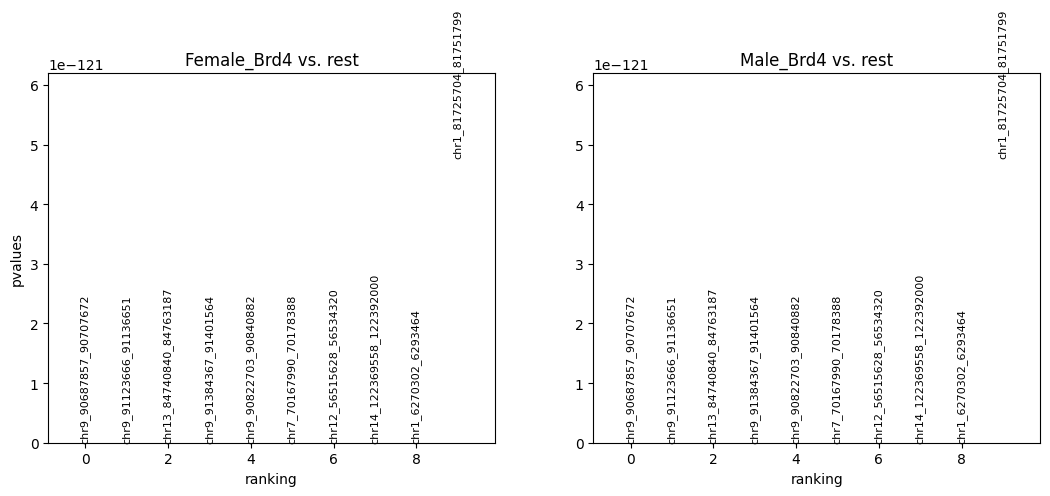

In [17]:
cc.pl.rank_peak_groups(adata_cc, key = 'fisher_exact', rankby = 'pvalues')

We can use Pycallingcards to look at the insertion densities at peaks that are differentially bound.  In the plot below, we first plot female peaks as blue points and male as grey points, and then we plot male peaks as red and female peaks as grey.  From the plots below we can see there is much more Brd4 binding at this locus in females than in males.  

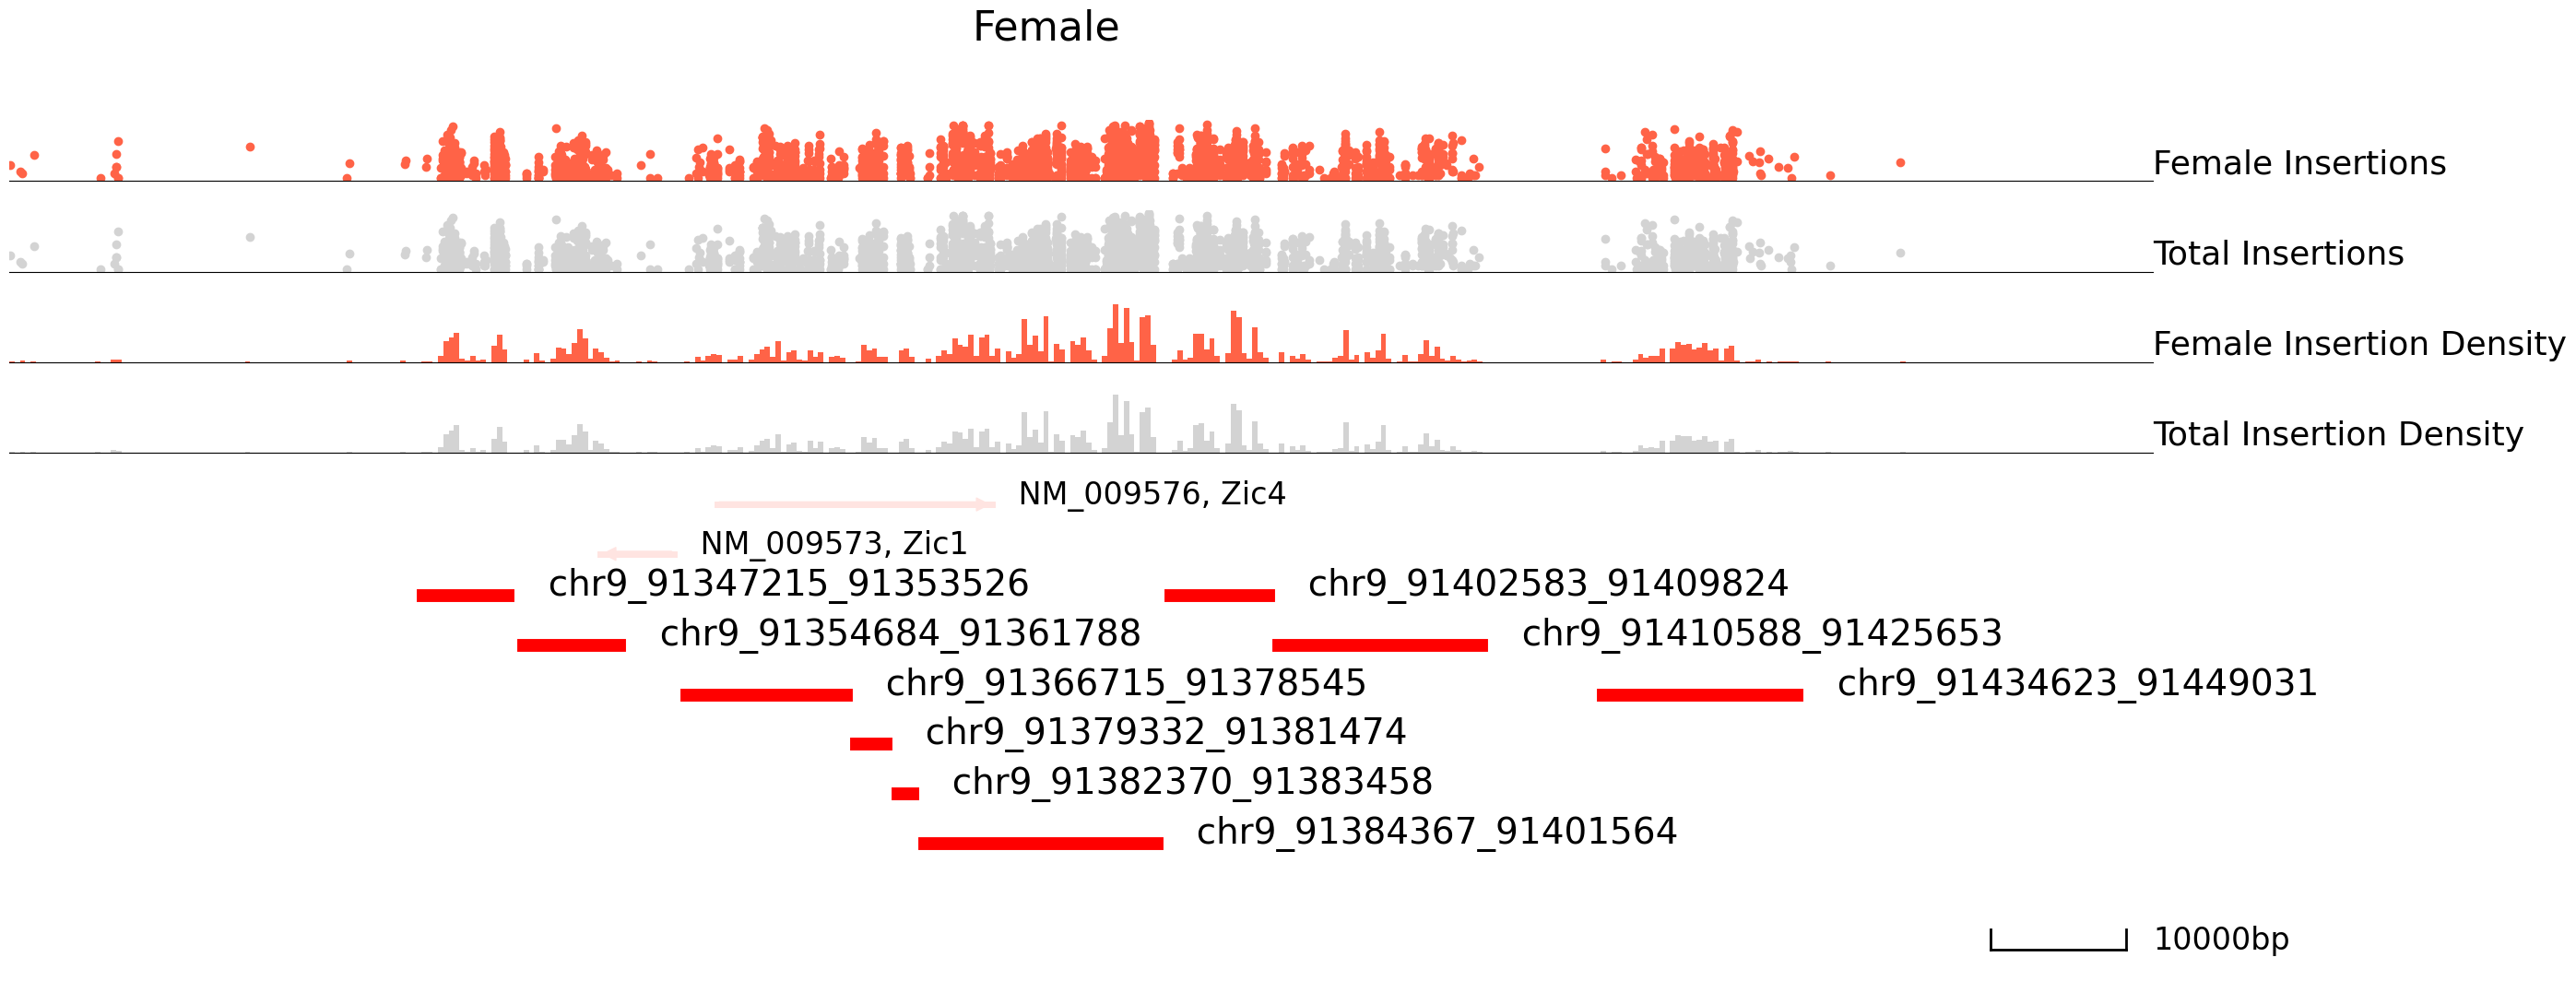

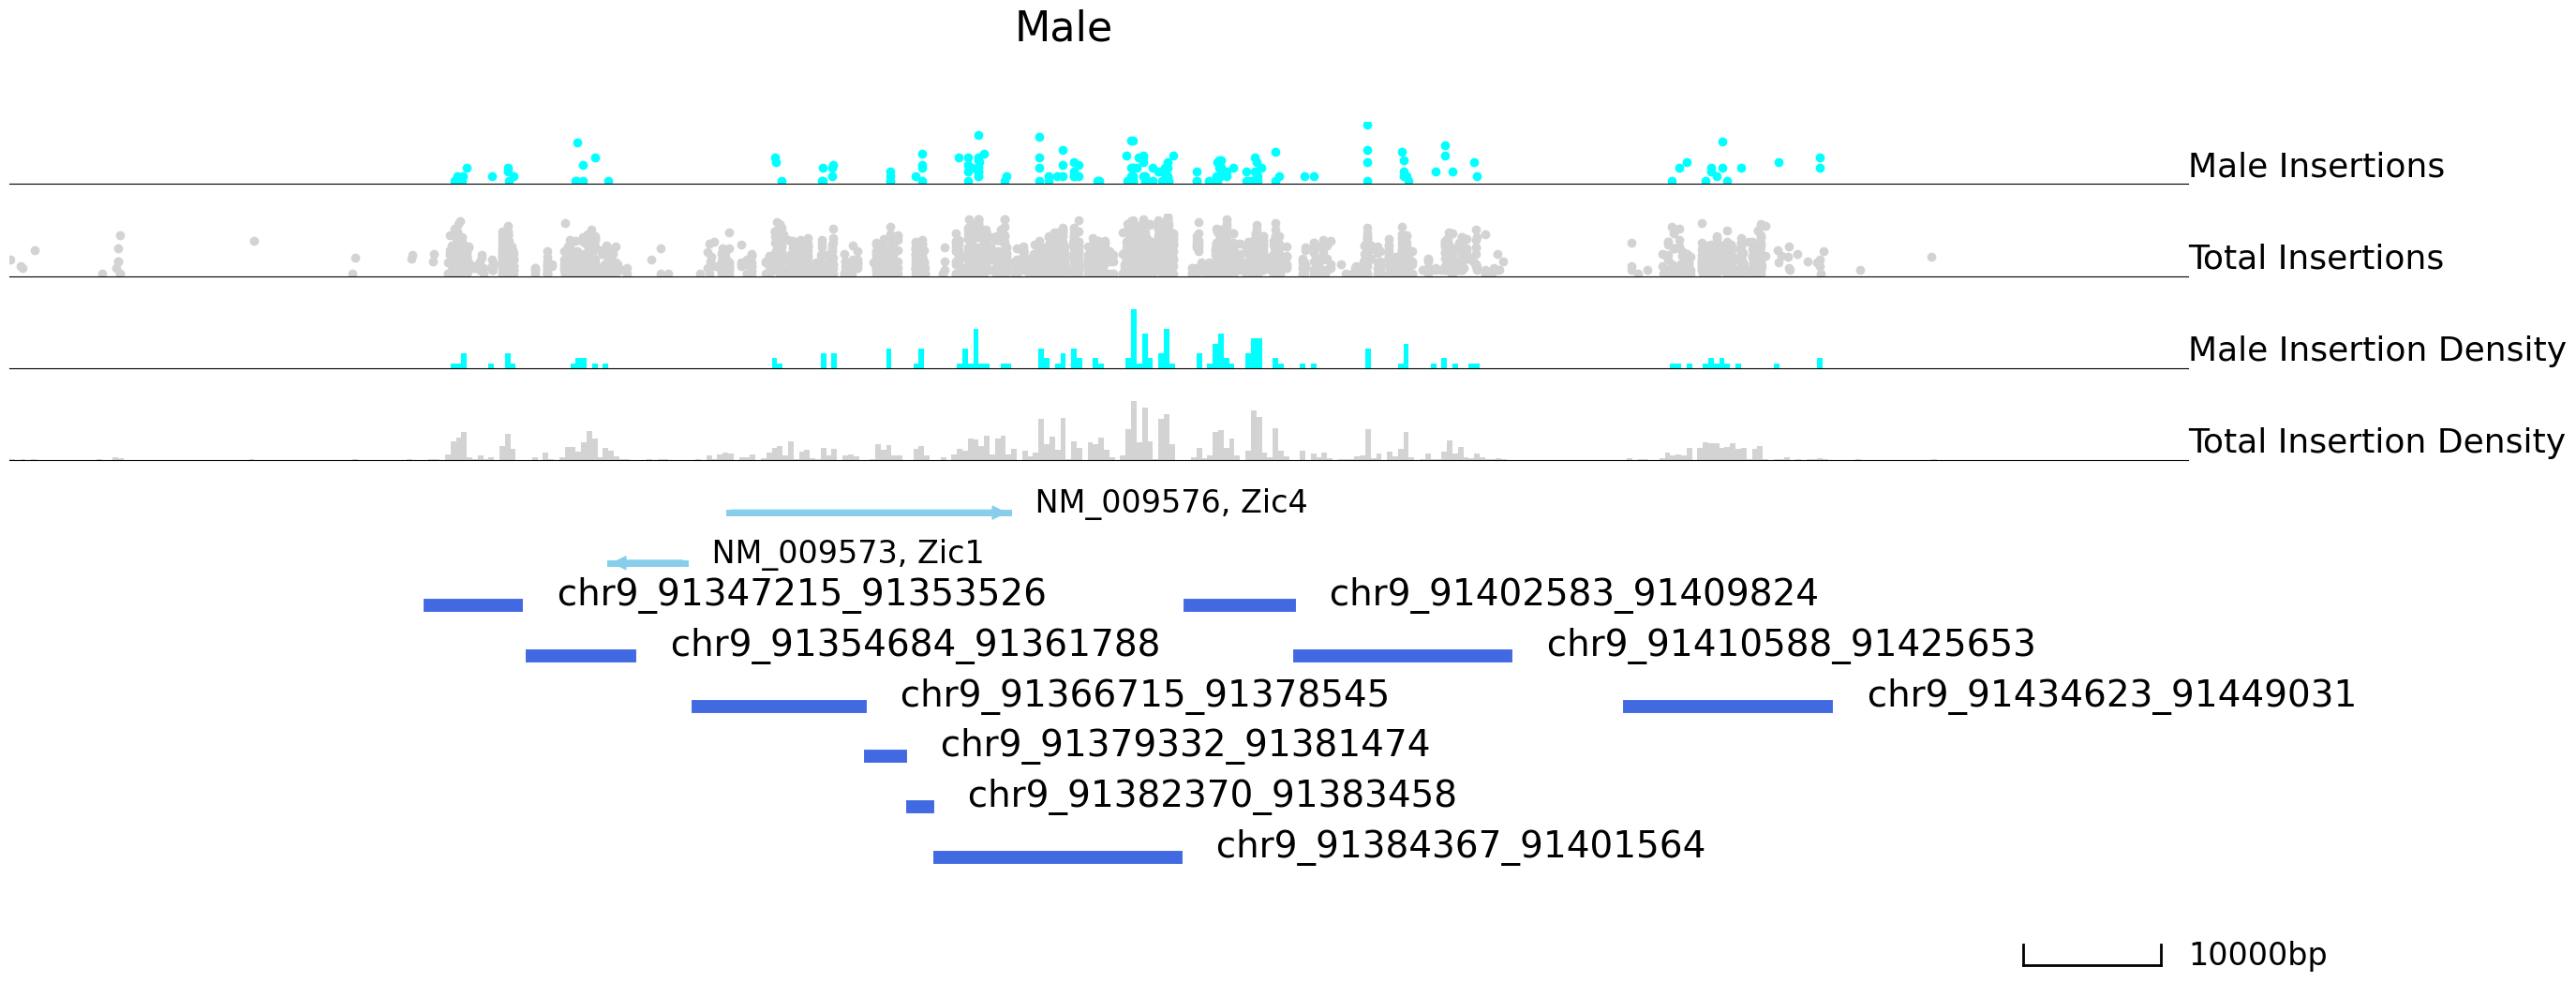

In [18]:
cc.pl.draw_area("chr9", 91366534, 91425373, 50000, peak_data, Brd4, "mm10", adata = adata_cc, font_size=2, 
                plotsize = [1,1,4], name = "Female_Brd4",key = "Index",insertionkey = "group", 
                name_insertion1 = 'Female Insertions', name_density1 = 'Female Insertion Density',
                name_insertion2 = 'Total Insertions', name_density2 = 'Total Insertion Density',
                bins = 400, figsize = (30,12), peak_line = 6, title = "Female")
cc.pl.draw_area("chr9", 91366534, 91425373, 50000, peak_data, Brd4, "mm10",  adata = adata_cc, font_size=2, 
                plotsize = [1,1,4], name = "Male_Brd4",key = "Index", insertionkey = "group",
                name_insertion1 = 'Male Insertions', name_density1 = 'Male Insertion Density',
                name_insertion2 = 'Total Insertions', name_density2 = 'Total Insertion Density',
                bins = 400, figsize = (30,12), peak_line = 6, color = "blue", title = "Male")

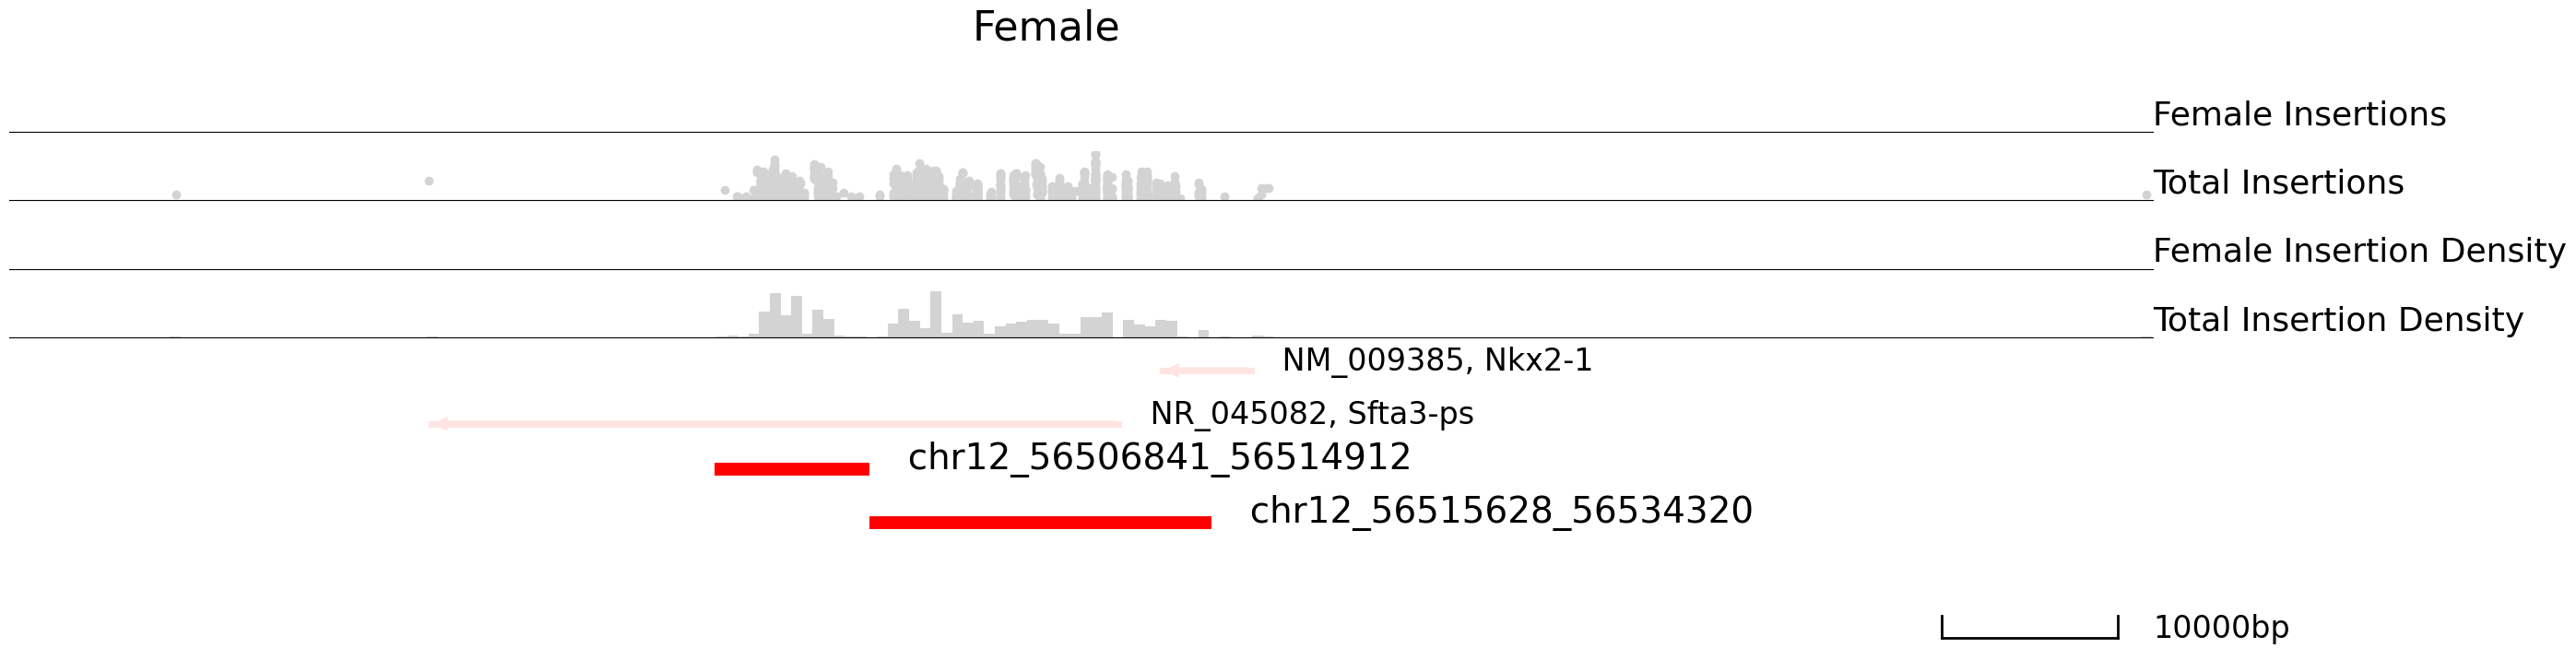

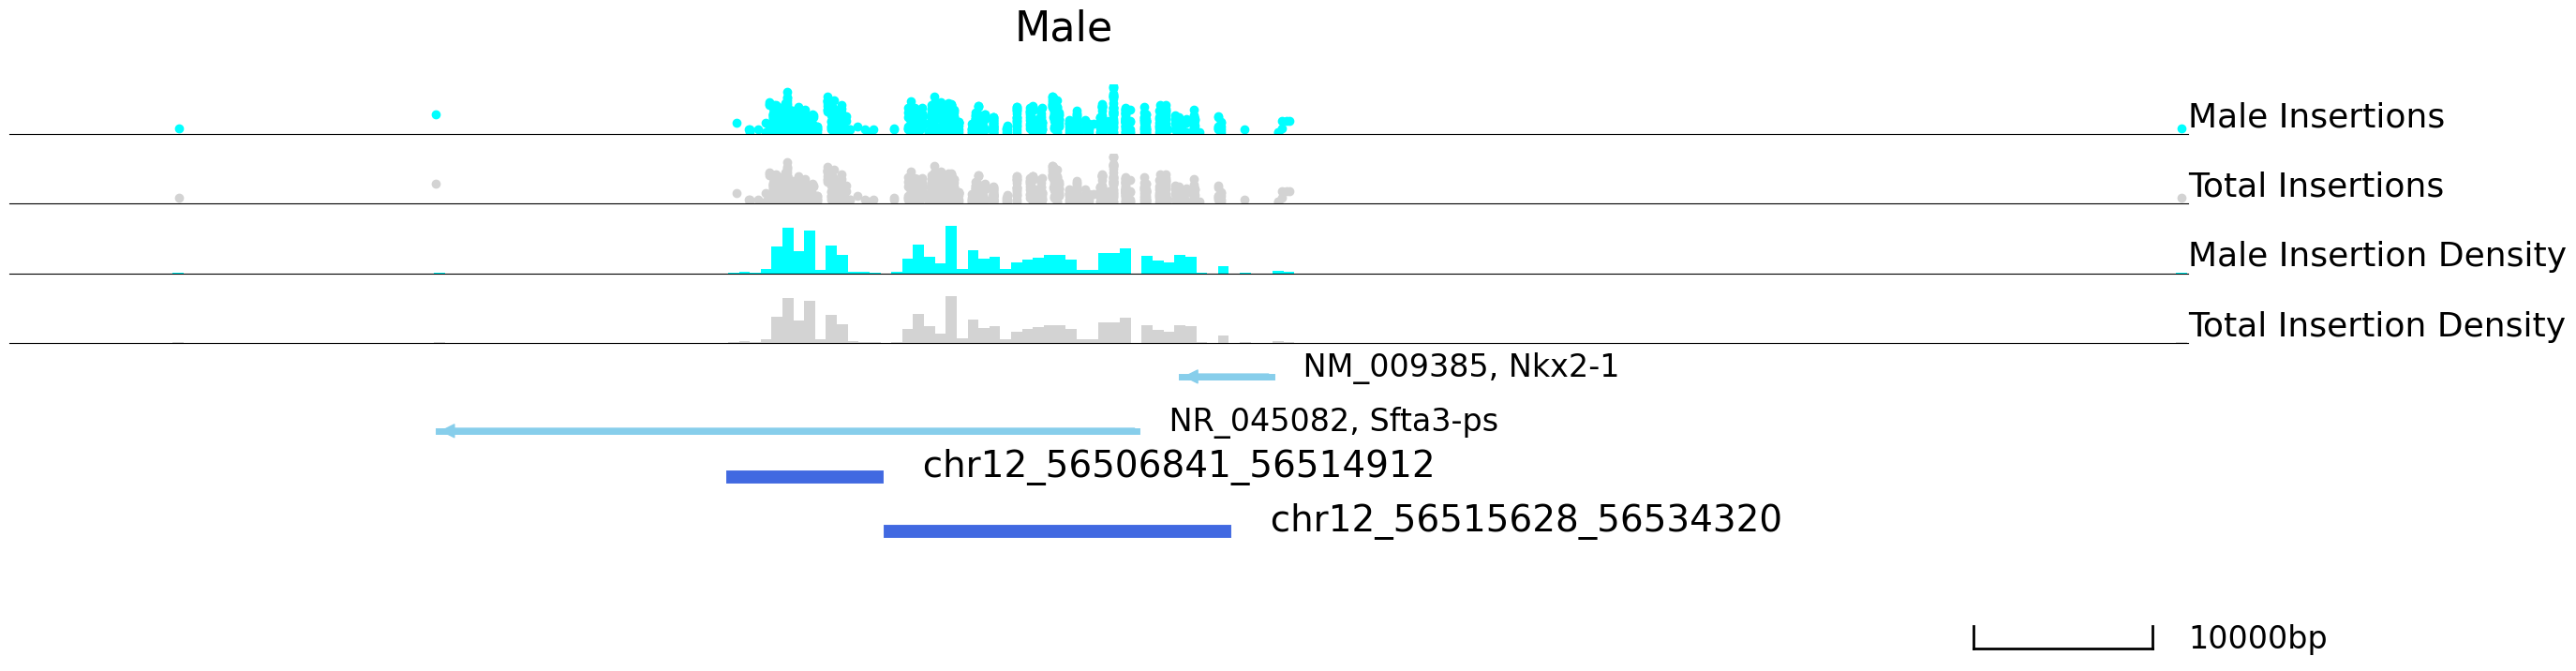

In [19]:
cc.pl.draw_area("chr12", 56516453, 56538107, 50000, peak_data, Brd4, "mm10", adata = adata_cc, font_size=2, 
                plotsize = [1,1,3], name = "Female_Brd4", key = "Index",insertionkey = "group", bins = 200,
                name_insertion1 = 'Female Insertions', name_density1 = 'Female Insertion Density',
                name_insertion2 = 'Total Insertions', name_density2 = 'Total Insertion Density',
                figsize = (30,8), peak_line = 2, title = "Female")
cc.pl.draw_area("chr12", 56516453, 56538107, 50000, peak_data, Brd4, "mm10", adata = adata_cc, font_size=2, 
                plotsize = [1,1,3], name = "Male_Brd4", key = "Index", insertionkey = "group", bins = 200,
                name_insertion1 = 'Male Insertions', name_density1 = 'Male Insertion Density',
                name_insertion2 = 'Total Insertions', name_density2 = 'Total Insertion Density',
                figsize = (30,8), peak_line = 2, color = "blue", title = "Male")

We can now plot a volcano plot to visualize the distribution of differentially bound peaks. labelright and labellest are the location points of the labels.

/scratch/rmlab/rmlab_shared/g.juanru/pycallingcards/pycallingcards/pycallingcards/plotting/_volcano.py:70: RuntimeWarning: divide by zero encountered in log10
  pva = -np.log10(np.array(adata_cc.uns[name][pvalue_name].tolist())[:, 1])


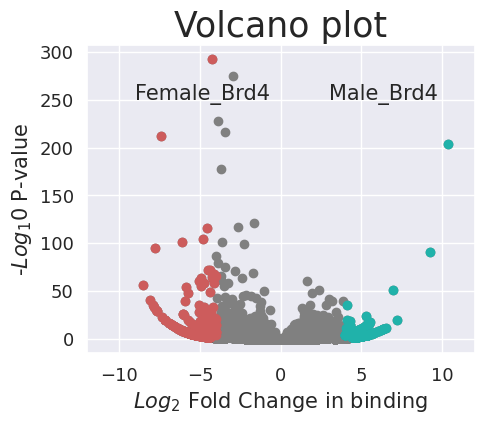

In [20]:
cc.pl.volcano_plot(adata_cc, pvalue_name = 'pvalues_adj', pvalue_cutoff = 0.01, lfc_cutoff = 4,
                   figsize = (5,4), labelright = (3,250), labelleft = (-9,250))

We can now use [HOMER](http://homer.ucsd.edu/homer/motif/) to call motifs for both female and male bound peaks separately to find out potential motif binding difference.

In [21]:
cc.tl.call_motif(peaks_frame=cc.tl.rank_peak_groups_df(adata_cc, key = 'fisher_exact', pval_cutoff = 0.01, logfc_min = 3, group = ['Female_Brd4'])["names"].str.split("_", expand=True),
                 reference ="mm10",save_homer = "Homer/GBM_female", 
                 homer_path = "/ref/rmlab/software/homer/bin", num_cores=8)
cc.tl.call_motif(peaks_frame=cc.tl.rank_peak_groups_df(adata_cc, key = 'fisher_exact', pval_cutoff = 0.01, logfc_min = 3, group = ['Male_Brd4'])["names"].str.split("_", expand=True),
                 reference ="mm10",save_homer = "Homer/GBM_male", 
                 homer_path = "/ref/rmlab/software/homer/bin", num_cores=8)

There is no save_name, it will save to temp_Homer_trial.bed and then delete.



	Position file = temp_Homer_trial.bed
	Genome = mm10
	Output Directory = Homer/GBM_female
	Fragment size set to 1000
	Using 8 CPUs
	Will not run homer for de novo motifs
	Found mset for "mouse", will check against vertebrates motifs
	Peak/BED file conversion summary:
		BED/Header formatted lines: 1009
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 1009
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 1000 bp fragments found.

	Extracting sequences from directory: /ref/rmlab/software/homer/.//data/genomes/mm10//
	Extracting 96 sequences from chr1
	Extracting 93 sequences from chr2
	Extracting 62 sequences from chr3
	Extracting 39 sequences from chr4
	Extracting 67 sequences from chr5
	Extracting 66 sequences from chr6
	Extracting 62 sequences from chr7


Finished!
There is no save_name, it will save to temp_Homer_trial.bed and then delete.



	Peak File Statistics:
		Total Peaks: 585
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 1000 bp fragments found.

	Extracting sequences from directory: /ref/rmlab/software/homer/.//data/genomes/mm10//
	Extracting 36 sequences from chr1
	Extracting 40 sequences from chr2
	Extracting 33 sequences from chr3
	Extracting 20 sequences from chr4
	Extracting 28 sequences from chr5
	Extracting 35 sequences from chr6
	Extracting 18 sequences from chr7
	Extracting 25 sequences from chr8
	Extracting 21 sequences from chr9
	Extracting 52 sequences from chr10
	Extracting 39 sequences from chr11
	Extracting 26 sequences from chr12
	Extracting 23 sequences from chr13
	Extracting 36 sequences from chr14
	Extracting 43 sequences from chr15
	Extracting 18 sequences from chr16
	Extracting 1

Finished!


	Skipping...
	Job finished - if results look good, please send beer to ..

	Cleaning up tmp files...



Find motifs under male peaks but not in female peaks.

In [22]:
cc.tl.compare_motif("Homer/GBM_male", "Homer/GBM_female")

,Motif Name,Consensus,P-value,Log P-value,q-value (Benjamini),# of Target Sequences with Motif(of 585),% of Target Sequences with Motif,# of Background Sequences with Motif(of 48620),% of Background Sequences with Motif
7,Nrf2(bZIP)/Lymphoblast-Nrf2-ChIP-Seq(GSE37589)...,HTGCTGAGTCAT,1.000000e-10,-24.900,0.0000,39.0,6.67%,901.5,1.85%
8,NF-E2(bZIP)/K562-NFE2-ChIP-Seq(GSE31477)/Homer,GATGACTCAGCA,1.000000e-09,-21.850,0.0000,41.0,7.01%,1093.8,2.25%
9,Bach1(bZIP)/K562-Bach1-ChIP-Seq(GSE31477)/Homer,AWWNTGCTGAGTCAT,1.000000e-08,-18.790,0.0000,39.0,6.67%,1122.3,2.31%
10,MafK(bZIP)/C2C12-MafK-ChIP-Seq(GSE36030)/Homer,GCTGASTCAGCA,1.000000e-06,-15.430,0.0000,97.0,16.58%,4744.4,9.76%
11,Ets1-distal(ETS)/CD4+-PolII-ChIP-Seq(Barski et...,MACAGGAAGT,1.000000e-05,-12.660,0.0001,116.0,19.83%,6357.8,13.08%
13,Sox3(HMG)/NPC-Sox3-ChIP-Seq(GSE33059)/Homer,CCWTTGTY,1.000000e-04,-9.813,0.0010,434.0,74.19%,32439.3,66.72%
16,Sox10(HMG)/SciaticNerve-Sox3-ChIP-Seq(GSE35132...,CCWTTGTYYB,1.000000e-03,-7.802,0.0063,407.0,69.57%,30578.6,62.89%
17,TATA-Box(TBP)/Promoter/Homer,CCTTTTAWAGSC,1.000000e-03,-7.415,0.0088,382.0,65.30%,28531.9,58.68%
18,Sox4(HMG)/proB-Sox4-ChIP-Seq(GSE50066)/Homer,YCTTTGTTCC,1.000000e-03,-7.401,0.0088,255.0,43.59%,17985.6,36.99%
20,Lhx2(Homeobox)/HFSC-Lhx2-ChIP-Seq(GSE48068)/Homer,TAATTAGN,1.000000e-03,-7.005,0.0114,343.0,58.63%,25344.1,52.12%


Find motifs in female but not in male.

In [23]:
cc.tl.compare_motif("Homer/GBM_female", "Homer/GBM_male")

,Motif Name,Consensus,P-value,Log P-value,q-value (Benjamini),# of Target Sequences with Motif(of 1009),% of Target Sequences with Motif,# of Background Sequences with Motif(of 48610),% of Background Sequences with Motif
0,Chop(bZIP)/MEF-Chop-ChIP-Seq(GSE35681)/Homer,ATTGCATCAT,1.000000e-19,-44.980,0.0000,197.0,19.52%,4807.5,9.89%
1,Atf4(bZIP)/MEF-Atf4-ChIP-Seq(GSE35681)/Homer,MTGATGCAAT,1.000000e-17,-40.070,0.0000,228.0,22.60%,6179.6,12.72%
3,ISRE(IRF)/ThioMac-LPS-Expression(GSE23622)/Homer,AGTTTCASTTTC,1.000000e-16,-38.810,0.0000,100.0,9.91%,1850.1,3.81%
7,IRF2(IRF)/Erythroblas-IRF2-ChIP-Seq(GSE36985)/...,GAAASYGAAASY,1.000000e-14,-33.450,0.0000,118.0,11.69%,2588.9,5.33%
10,IRF1(IRF)/PBMC-IRF1-ChIP-Seq(GSE43036)/Homer,GAAAGTGAAAGT,1.000000e-10,-24.850,0.0000,147.0,14.57%,3999.6,8.23%
11,Rbpj1(?)/Panc1-Rbpj1-ChIP-Seq(GSE47459)/Homer,HTTTCCCASG,1.000000e-07,-17.960,0.0000,594.0,58.87%,24358.2,50.14%
12,CEBP:AP1(bZIP)/ThioMac-CEBPb-ChIP-Seq(GSE21512...,DRTGTTGCAA,1.000000e-06,-15.840,0.0000,420.0,41.63%,16417.1,33.79%
13,GABPA(ETS)/Jurkat-GABPa-ChIP-Seq(GSE17954)/Homer,RACCGGAAGT,1.000000e-06,-14.460,0.0000,379.0,37.56%,14730.0,30.32%
14,NF1-halfsite(CTF)/LNCaP-NF1-ChIP-Seq(Unpublish...,YTGCCAAG,1.000000e-05,-12.190,0.0001,578.0,57.28%,24438.9,50.30%
15,Unknown-ESC-element(?)/mES-Nanog-ChIP-Seq(GSE1...,CACAGCAGGGGG,1.000000e-04,-11.060,0.0003,223.0,22.10%,8242.2,16.96%


Next, we want to identify differentially bound peaks whose nearby genes are differentially expressed between males and females. To do so, we must first read in the bulk RNA-seq data. Note that this RNA-seq data is normalized by [RPKM](https://wiki.arrayserver.com/wiki/index.php?title=RPKM).

In [24]:
rna =  cc.datasets.mouse_brd4_data(data = "RNA")
rna

,sample.f6_dmso_3,sample.f6_dmso_2,sample.f6_dmso_1,sample.m6_dmso_3,sample.m6_dmso_2,sample.m6_dmso_1
mt-Tf,0.000000,0.639272,0.000000,1.156308,0.000000,0.687531
mt-Rnr1,127.907281,184.396768,172.544723,130.417054,192.566581,114.212201
mt-Tv,0.000000,0.000000,1.761150,0.000000,0.510777,0.000000
mt-Rnr2,247.267306,527.855824,324.345998,675.031187,684.376279,418.345603
mt-Tl1,44.418710,117.660098,70.481211,167.217607,115.129081,127.789076
...,...,...,...,...,...,...
Gm16897,0.281553,0.349020,0.463442,0.078913,0.070742,0.112610
A330023F24Rik,0.118678,0.055749,0.058441,0.029411,0.018833,0.049965
Cd46,0.127930,0.095151,0.075997,0.061467,0.055103,0.087715
Cr1l,9.993119,14.027801,13.717564,13.586101,13.240219,11.089902


We now plot the heatmap for calling cards data and gene expression data. 

The top lines are the relative Brd4 binding for each of the two groups. The bottom lines are the gene expressions of the top two nearest genes in the 3 RNA-seq replicates for males and females; each gene shown separately. 

We can see a relationship between Brd4 binding and the expression of nearby genes. Genes that are strongly bound in females tend to be expressed in females and expressed at lower levels in males and vice versa. The effect is much more muted for the 2nd nearest gene to the peak. 

Please make sure that the samples in adata_cc and rna are in the same order.


/scratch/rmlab/rmlab_shared/g.juanru/pycallingcards/pycallingcards/pycallingcards/plotting/_heatmap_ccrna.py:191: RuntimeWarning: invalid value encountered in divide
  data[groupnumber:secondnum, :]
/scratch/rmlab/rmlab_shared/g.juanru/pycallingcards/pycallingcards/pycallingcards/plotting/_heatmap_ccrna.py:193: RuntimeWarning: invalid value encountered in divide
  data[secondnum:, :]


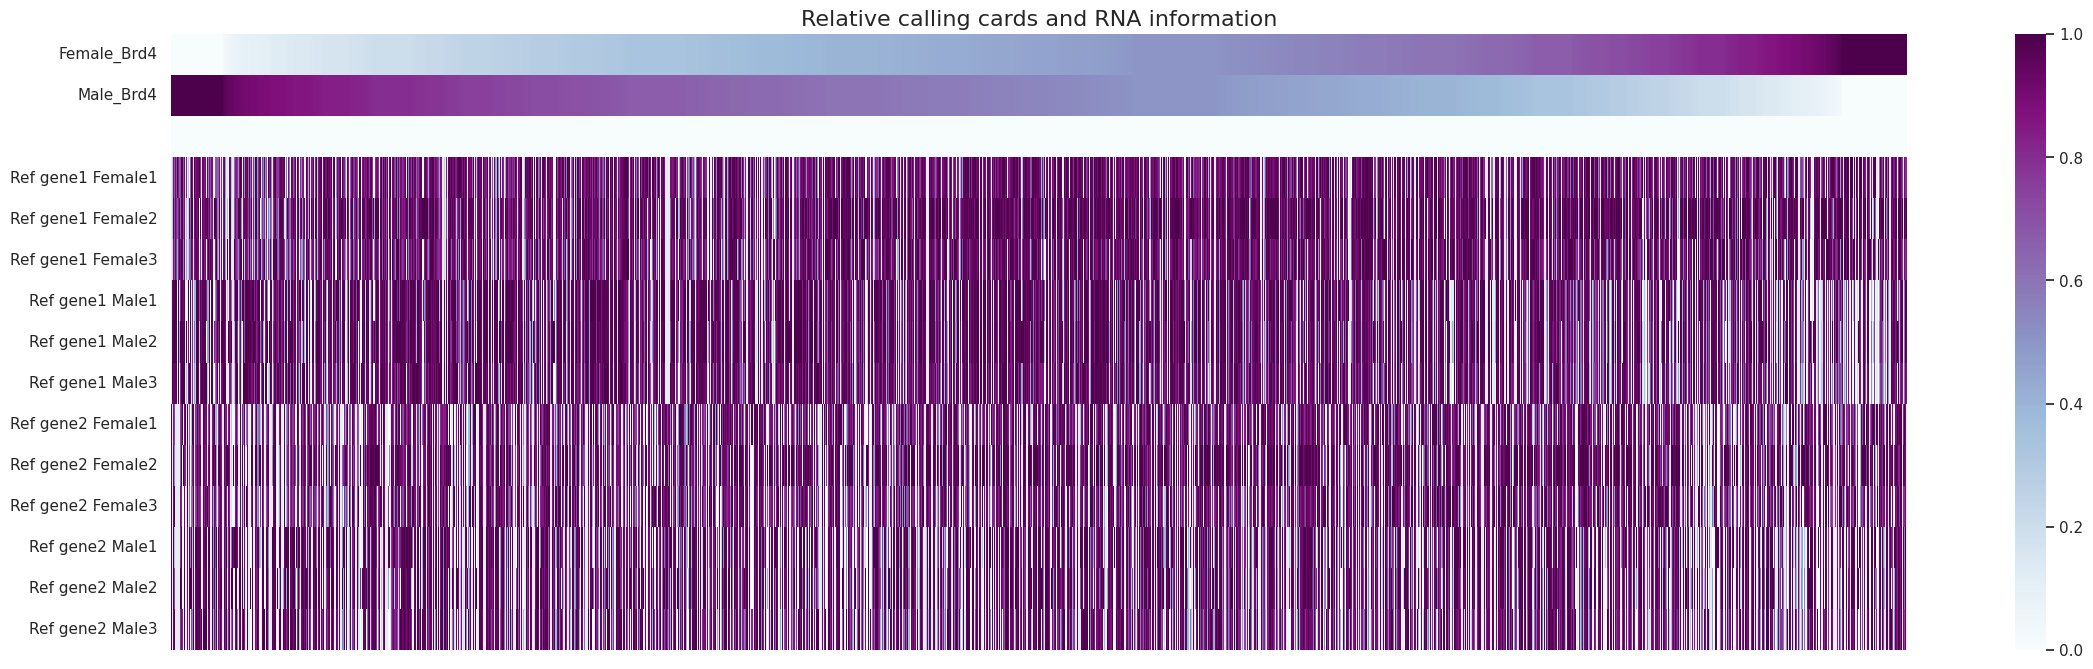

In [25]:
cc.pl.heatmap(adata_cc,rna, rnalabels = ["Female1", "Female2", "Female3","Male1", "Male2", "Male3"])

Find out the co-differential peak-gene pairs. Look into all the differential peaks and then see if the annotated genes are also significantly expressed. We can set the pvalue and score/log foldchange cutoff easily.


In [26]:
result = cc.tl.pair_peak_gene_bulk(adata_cc, "https://github.com/The-Mitra-Lab/pycallingcards_data/releases/download/data/deseq_MF.csv",
                                   name_cc = 'logfoldchanges', pvalue_cutoff_cc = 0.001, pvalue_cutoff_rna = 0.001, 
                                   lfc_cutoff_rna = 5, lfc_cutoff_cc = 5)
result

,Peak,logfoldchanges_peak,Pvalue_peak,Pvalue_adj_peak,Gene,Score_gene,Pvalue_gene,Pvalue_adj_gene
0,chr1_174659622_174662521,5.652435,1.530047e-08,4.586591e-07,Grem2,-10.401831,1.280025e-67,1.252748e-65
1,chr1_174917639_174921559,6.208699,2.711848e-12,1.562878e-10,Grem2,-10.401831,1.280025e-67,1.252748e-65
2,chr2_93645657_93648162,5.189615,2.360560e-06,4.324934e-05,Alx4,-10.292504,5.458739e-18,1.081356e-16
3,chr3_33140350_33142508,5.534632,6.455627e-08,1.724615e-06,Pex5l,-7.590236,2.351122e-24,6.841972e-23
4,chr3_126498429_126499612,5.337659,5.594815e-07,1.202787e-05,Arsj,-6.281259,8.667831e-27,2.783525e-25
5,chr3_126657669_126660188,-5.397757,5.546104e-07,1.202787e-05,Arsj,-6.281259,8.667831e-27,2.783525e-25
6,chr3_132085669_132092999,6.121213,1.509244e-105,2.850264e-102,Dkk2,-6.916087,9.389039e-178,5.513378e-175
7,chr3_132093815_132106295,5.072335,9.590057e-65,6.924867e-62,Dkk2,-6.916087,9.389039e-178,5.513378e-175
8,chr3_141699368_141702608,6.065565,2.403341e-29,5.413249e-27,Bmpr1b,-5.570116,6.893076e-40,3.655998e-38
9,chr4_68535893_68538867,5.172571,1.974087e-15,1.648497e-13,Brinp1,-7.758307,5.384595e-10,5.726618e-09


Next, we visualize, for specific peaks, the magnitude of differential binding and the expression of nearby genes using the dotplot function.  This function creates a dotplot with three columns (below).  The first shows the relative binding of Brd4 at a chromsomal locus in males and females, the second and third columns show the expression levels of the nearest and second nearest genes in males and females. 

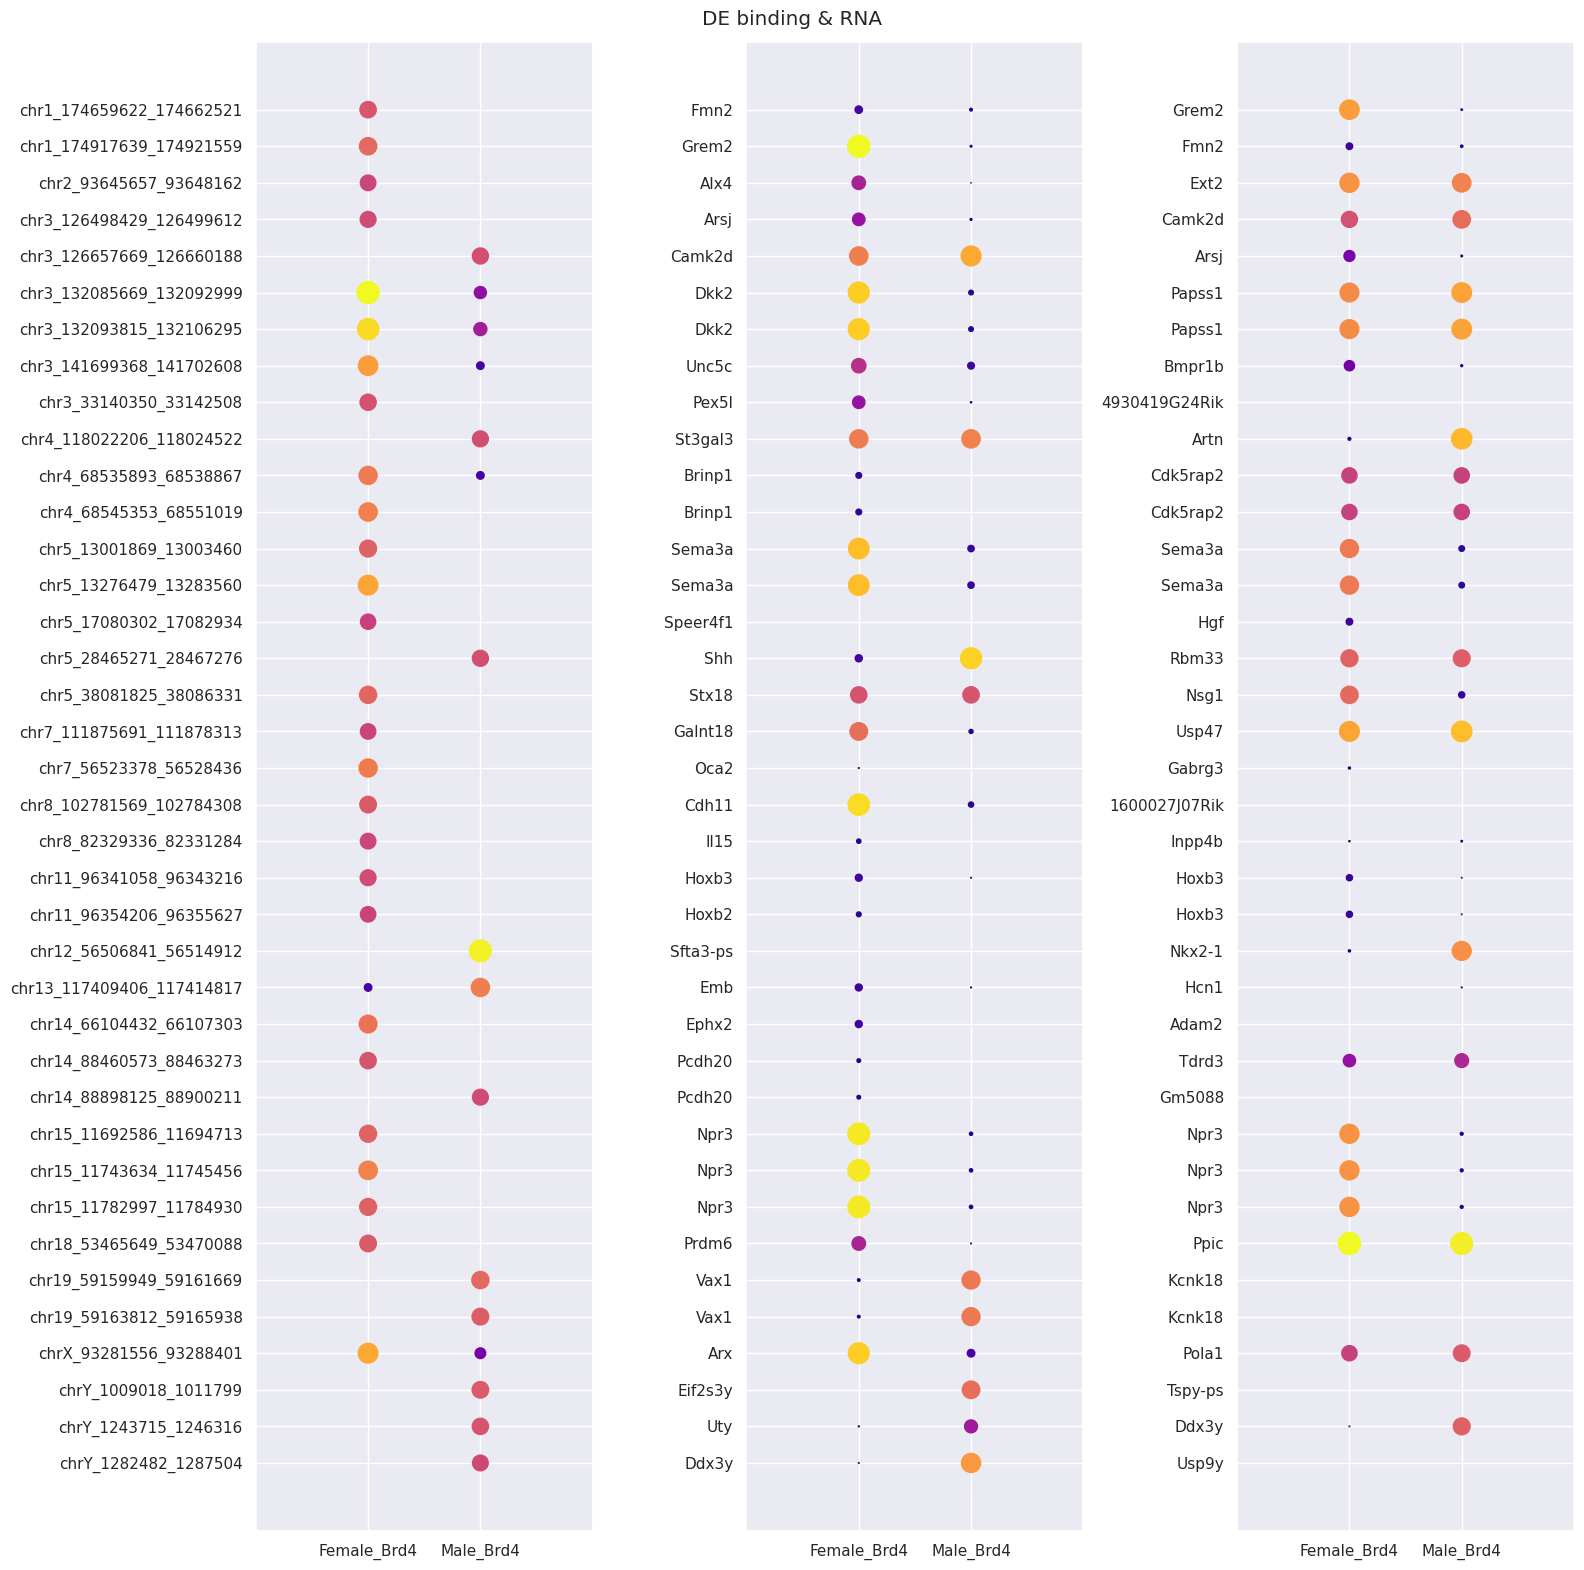

In [27]:
cc.pl.dotplot_bulk(adata_cc, rna, selected_list = list(np.unique(np.array(result["Peak"]))), num_list = [3,3], 
                   cmap = 'plasma', figsize = (16, 16), sort_by_chrom = True, topspace = 0.96)

We can see from these results that all of the peaks visualized here display differential binding, and either the nearest, or second nearest gene has differential expression. In most cases, increased Brd4 binding is associated with an increase in gene expression. 

Pycallingcards provides functionality to explore relatinoships between differentially bound regions and nearby GWAS identified SNPs. Since the data analyzed here were collected in murine cells, we must first lift over any interesting peaks to the human genome before we can look for nearby disease associated SNPs. We use [liftover](https://genome.ucsc.edu/cgi-bin/hgLiftOver) to get the resuls.

In [28]:
result = cc.tl.result_mapping(result)
result

Start mapping the peaks to the new genome.


100%|██████████| 46/46 [00:00<00:00, 56.99it/s] 


Start finding location of genes in the new genome.


100%|██████████| 46/46 [00:00<00:00, 213.99it/s]


,Peak,logfoldchanges_peak,Pvalue_peak,Pvalue_adj_peak,Gene,Score_gene,Pvalue_gene,Pvalue_adj_gene,Chr_liftover,Start_liftover,End_liftover,Chr_hg38,Start_hg38,End_hg38
0,chr1_174659622_174662521,5.652435,1.530047e-08,4.586591e-07,Grem2,-10.401831,1.280025e-67,1.252748e-65,chr1,240280756,240283835,chr1,240489572,240612162
1,chr1_174917639_174921559,6.208699,2.711848e-12,1.562878e-10,Grem2,-10.401831,1.280025e-67,1.252748e-65,chr1,240608636,240611870,chr1,240489572,240612162
2,chr2_93645657_93648162,5.189615,2.360560e-06,4.324934e-05,Alx4,-10.292504,5.458739e-18,1.081356e-16,chr11,44303696,44306415,chr11,44260727,44310166
3,chr3_33140350_33142508,5.534632,6.455627e-08,1.724615e-06,Pex5l,-7.590236,2.351122e-24,6.841972e-23,chr3,180033883,180036186,chr3,179794958,180037053
4,chr3_126498429_126499612,5.337659,5.594815e-07,1.202787e-05,Arsj,-6.281259,8.667831e-27,2.783525e-25,chr4,113839066,113844568,chr4,113900283,113979722
5,chr3_126657669_126660188,-5.397757,5.546104e-07,1.202787e-05,Arsj,-6.281259,8.667831e-27,2.783525e-25,chr4,113683844,113686758,chr4,113900283,113979722
6,chr3_132085669_132092999,6.121213,1.509244e-105,2.850264e-102,Dkk2,-6.916087,9.389039e-178,5.513378e-175,chr4,107029387,107035946,chr4,106921801,107036296
7,chr3_132093815_132106295,5.072335,9.590057e-65,6.924867e-62,Dkk2,-6.916087,9.389039e-178,5.513378e-175,chr4,107015456,107028826,chr4,106921801,107036296
8,chr3_141699368_141702608,6.065565,2.403341e-29,5.413249e-27,Bmpr1b,-5.570116,6.893076e-40,3.655998e-38,chr4,95306647,95309431,chr4,94757976,95158450
9,chr4_68535893_68538867,5.172571,1.974087e-15,1.648497e-13,Brinp1,-7.758307,5.384595e-10,5.726618e-09,chr9,118993297,118996641,chr9,119166629,119369461


In [29]:
GWAS_result = cc.tl.GWAS(result)
GWAS_result

,Peak,logfoldchanges_peak,Pvalue_peak,Pvalue_adj_peak,Gene,Score_gene,Pvalue_gene,Pvalue_adj_gene,Chr_liftover,Start_liftover,End_liftover,Chr_hg38,Start_hg38,End_hg38,GWAS
0,chr1_174659622_174662521,5.652435,1.530047e-08,4.586591e-07,Grem2,-10.401831,1.280025e-67,1.252748e-65,chr1,240280756,240283835,chr1,240489572,240612162,Coronary heart disease
1,chr1_174917639_174921559,6.208699,2.711848e-12,1.562878e-10,Grem2,-10.401831,1.280025e-67,1.252748e-65,chr1,240608636,240611870,chr1,240489572,240612162,
2,chr2_93645657_93648162,5.189615,2.360560e-06,4.324934e-05,Alx4,-10.292504,5.458739e-18,1.081356e-16,chr11,44303696,44306415,chr11,44260727,44310166,
3,chr3_33140350_33142508,5.534632,6.455627e-08,1.724615e-06,Pex5l,-7.590236,2.351122e-24,6.841972e-23,chr3,180033883,180036186,chr3,179794958,180037053,
4,chr3_126498429_126499612,5.337659,5.594815e-07,1.202787e-05,Arsj,-6.281259,8.667831e-27,2.783525e-25,chr4,113839066,113844568,chr4,113900283,113979722,
5,chr3_126657669_126660188,-5.397757,5.546104e-07,1.202787e-05,Arsj,-6.281259,8.667831e-27,2.783525e-25,chr4,113683844,113686758,chr4,113900283,113979722,
6,chr3_132085669_132092999,6.121213,1.509244e-105,2.850264e-102,Dkk2,-6.916087,9.389039e-178,5.513378e-175,chr4,107029387,107035946,chr4,106921801,107036296,
7,chr3_132093815_132106295,5.072335,9.590057e-65,6.924867e-62,Dkk2,-6.916087,9.389039e-178,5.513378e-175,chr4,107015456,107028826,chr4,106921801,107036296,
8,chr3_141699368_141702608,6.065565,2.403341e-29,5.413249e-27,Bmpr1b,-5.570116,6.893076e-40,3.655998e-38,chr4,95306647,95309431,chr4,94757976,95158450,
9,chr4_68535893_68538867,5.172571,1.974087e-15,1.648497e-13,Brinp1,-7.758307,5.384595e-10,5.726618e-09,chr9,118993297,118996641,chr9,119166629,119369461,"Gut microbiota (bacterial taxa, hurdle binary ..."


Save the file if needed.

In [30]:
adata_cc.write("Brd4_bindings_bulk.h5ad")